In [1]:
try: 
    from imutils import paths 
except:
    !pip install imutils
    from imutils import paths 
    
try: 
    import tensorflow_similarity as tfsim
except: 
    %pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=816924e93d1a1d1520248355fa0bebab2094e0d5906a73e630044f310bd8ac86
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=861955 sha256=93b764d1075f0a1426a990401605dc12db0a3923968a8f8a0fd29e1ce3689396
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.10.4
    Uninstalling pybind11-2

In [2]:
import os 
from tqdm import tqdm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import shutil
import cv2 
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Input, Lambda, Conv2D, MaxPooling2D, \
                                    GlobalAveragePooling2D, ReLU, ELU,BatchNormalization
from tensorflow.keras.models import Model 

In [3]:
DATA_DIR_PATH = "/kaggle/input/stl10"
TRAIN_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, "train_images")
TEST_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, "test_images")
UNLABELED_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, "unlabeled_images")
STL_IMG_SHAPE = 96

In [ ]:
unlabeled_image_files_path = list(paths.list_files(UNLABELED_DATA_DIR_PATH))

In [ ]:
# 100 thosand unlabelled images.
len(unlabeled_image_files_path) == 1_00_000

In [ ]:
plt.figure(figsize=(10, 10))
for i, image_path  in enumerate(unlabeled_image_files_path[:9]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(image_path)
    plt.imshow(img)
    plt.axis("off")

In [7]:
# Data Augumentation Pipeline.\
@tf.function
def gaussian_blur(img, ksize=5, sigma=1):
    def gaussian_kernel(size=3, sigma=1):

        x_range = tf.range(-(size-1)//2, (size-1)//2 + 1, 1)
        y_range = tf.range((size-1)//2, -(size-1)//2 - 1, -1)

        xs, ys = tf.meshgrid(x_range, y_range)
        kernel = tf.exp(-(xs**2 + ys**2)/(2*(sigma**2))) / (2*np.pi*(sigma**2))
        return tf.cast( kernel / tf.reduce_sum(kernel), tf.float32)
    
    kernel = gaussian_kernel(ksize, sigma)
    kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)
    
    r, g, b = tf.split(img, [1,1,1], axis=-1)
    r_blur = tf.nn.conv2d([r], kernel, [1,1,1,1], 'SAME')
    g_blur = tf.nn.conv2d([g], kernel, [1,1,1,1], 'SAME')
    b_blur = tf.nn.conv2d([b], kernel, [1,1,1,1], 'SAME')

    blur_image = tf.concat([r_blur, g_blur, b_blur], axis=-1)
    return tf.squeeze(blur_image, axis=0)

    
# color jitter and grayscale 
@tf.function
def random_color_distortion(image):
    """
        applys the random color distortion(jitter and grayscale).
    """
    color_jitter = tf.random.uniform(shape=[])
    if color_jitter < 0.8:
        image = tf.image.random_brightness(image, max_delta=0.4)
        image = tf.image.random_contrast(image, lower=0.6, upper=1.4)
        image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
        image = tf.image.random_hue(image, max_delta=0.1)
        image = tf.clip_by_value(image, 0, 1)

    # Color dropping
    color_drop = tf.random.uniform(shape=[])
    if color_drop < 0.2:
        image = tf.image.rgb_to_grayscale(image)
      #  image = tf.tile(image, [1, 1, 3])
    return image


@tf.function
def simsiam_dataaugumentation_pipeline(image, img_shape, blur):
    """
        this function apply multiple transformation to the image.
        Params:
            image(type: tf.Tensor): image, that needed to be transformed.
        Return(type: tensor.Tensor)
            returns the image with applying transformation.
    """
    image = tf.image.random_flip_left_right(image, seed=None)
    #image /= 255.0
    image = tf.image.random_crop(value=image, size=(48, 48, 3))
    image = tf.image.resize(image, [96, 96])
    image = tfsim.augmenters.augmentation_utils.random_apply.random_apply(grascayle_transform, p=0.2, x=image)
    
    if blur:
        image = tfsim.augmenters.augmentation_utils.blur.random_blur(image, p=0.5, height=32, width=32)
        
    image = image * 255.
    image = tf.clip_by_value(image, 0., 255.)
  #  return image
    return tf.cast(image, dtype="int64")

@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        img, STL_IMG_SHAPE, STL_IMG_SHAPE, area_range=area_range
    )
    
    # The following transforms expect the data to be [0, 1]
    img /= 255.
    
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "multiplicative",
        )

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_jitter_transform, p=0.8, x=img)

    # # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.to_grayscale(x)

    img = tfsim.augmenters.augmentation_utils.random_apply.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.augmentation_utils.blur.random_blur(img, p=0.5, height=32, width=32)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # scale the data back to [0, 255]
    img = img * 255.
    img = tf.clip_by_value(img, 0., 255.)

    return img

In [146]:
# Image preprocessing utils
@tf.function
def parse_images(image_path): 
    """
        this function, will read the image from the directory, and resize it to the 224 image shape, which is predefined 
        image shape of Resnet pretrained model.
        Params:
            image_path(type: str): image filepath in the directory.
        Return(type: tf.Image)
            returns the preprocessed image.
    """
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
 
    # creating a view1 and view2 by passing the image, to the augumentation pipeline.
    view1 = simsiam_augmenter(image, blur=False)
    view2 = simsiam_augmenter(image, blur=True)

    return (view1, view2)

def create_tensorflow_dataset(data, batch_size):
    """
        this function, will create the tensorflow dataset from the images.
        Params:
            data(type: List): list of data, in our case list contains the file path.
            batch_size(type: Int): batch size for the generator.
        Return(type: tf.data.Dataset)
            returns tensorflow dataset object.
    """
    tensorflow_data = tf.data.Dataset.from_tensor_slices(data)
    tensorflow_data = (
    tensorflow_data
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(1024)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return tensorflow_data   

In [147]:
unlabeled_train_ds = create_tensorflow_dataset(unlabeled_image_files_path, 128)

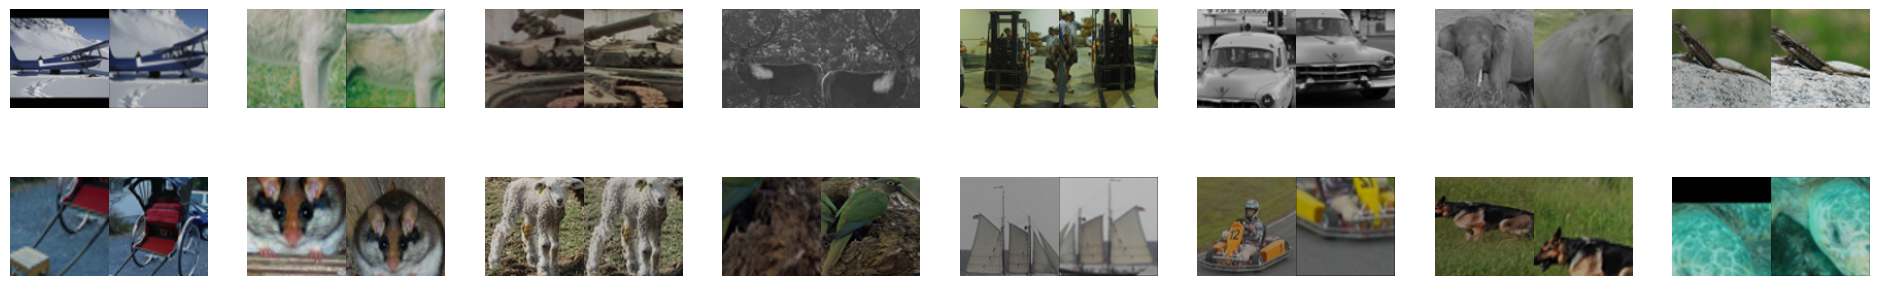

In [10]:
display_imgs = next(unlabeled_train_ds.as_numpy_iterator())
max_pixel = np.max([display_imgs[0].max(), display_imgs[1].max()])
min_pixel = np.min([display_imgs[0].min(), display_imgs[1].min()])

tfsim.visualization.visualize_views(
    views=display_imgs,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

In [11]:
class ProjectionHead(keras.models.Model):
    def __init__(self, out_dims=2048, hidden_dims=2048): 
        super(ProjectionHead, self).__init__()
        
        self.out_dims = out_dims
        self.hidden_dims = hidden_dims
        
        self.d1 = Dense(self.hidden_dims, use_bias=False)
        self.bn = BatchNormalization()
        self.d2 = Dense(self.hidden_dims, use_bias=False)
        self.out = Dense(self.out_dims)
        self.relu = ReLU()
        
    def call(self, inputs): 
        x = self.d1(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.d2(x)
        x = self.bn(x)
        x = self.relu(x)
       
        out = self.out(x)
        out = self.bn(out)
        
        return out
        

In [12]:
class PredictionHead(keras.models.Model):
    def __init__(self, out_dims=2048, hidden_dims=512): 
        super(PredictionHead, self).__init__()
        
        self.out_dims = out_dims
        self.hidden_dims = hidden_dims
        
        self.d1 = Dense(self.hidden_dims, use_bias=False)
        self.bn = BatchNormalization()
        self.out = Dense(self.out_dims)
        self.relu = ReLU()
        
    def call(self, inputs): 
        x = self.d1(inputs)
        x = self.bn(x)
        x = self.relu(x)
       
        out = self.out(x)        
        return out

In [13]:
class Encoder(keras.models.Model): 
    def __init__(self, input_dims, out_dims, preojection_head): 
        super(Encoder, self).__init__()
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        
        self.base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights=None, input_shape=self.input_dims)
        self.base_model.trainable = True
        self.gap = GlobalAveragePooling2D()
        self.projection_head = preojection_head
        
    def call(self, inputs): 
        x = self.base_model(inputs)
        x = self.gap(x)
        x = self.projection_head(x)
        
        return x         
        

In [14]:
class SimSiamNetwork(keras.models.Model):
    def __init__(self, input_dims, out_dims): 
        """
        The authors have also provided PyTorch-like psuedocode in the paper (how cool!) -
        # f: backbone + projection mlp
        # h: prediction mlp
        for x in loader: # load a minibatch x with n samples
            x1, x2 = aug(x), aug(x) # random augmentation
            z1, z2 = f(x1), f(x2) # projections, n-by-d
            p1, p2 = h(z1), h(z2) # predictions, n-by-d
            L = D(p1, z2)/2 + D(p2, z1)/2 # loss
            L.backward() # back-propagate
            update(f, h) # SGD update

        def D(p, z): # negative cosine similarity
            z = z.detach() # stop gradient
            p = normalize(p, dim=1) # l2-normalize
            z = normalize(z, dim=1) # l2-normalize
            return -(p*z).sum(dim=1).mean()
        """
        super(SimSiamNetwork, self).__init__()
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        
        self._projection_head = ProjectionHead(out_dims=2048, hidden_dims=2048)
        self._prediction_head = PredictionHead(out_dims=2048, hidden_dims=512)
        
        self._encoder = Encoder(self.input_dims, self.out_dims, self._projection_head)
        self._loss_tracker = keras.metrics.Mean()
        
    def call(self, inputs):
        x = self._encoder(inputs)
        return x 
    
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            view1, view2 = inputs
            z1, z2 = self._encoder(view1), self._encoder(view2)
            p1, p2 = self._prediction_head(z1), self._prediction_head(z2)
            loss_val = self._compute_loss(p1, z2)/2 + self._compute_loss(p2, z1)/2
            
        params = self._encoder.trainable_variables + self._prediction_head.trainable_variables
        grads = tape.gradient(loss_val, params)
        self.optimizer.apply_gradients(zip(grads, params))
        self._loss_tracker.update_state(loss_val)
        return {"loss": self._loss_tracker.result()}
    
    def test_step(self, inputs):
        pass
    
    def _metrics(self):
        pass
        
    def _compute_loss(self, p, z):
        z = tf.stop_gradient(z)
        p = tf.math.l2_normalize(p, axis=1)
        z = tf.math.l2_normalize(z, axis=1)
        return - tf.reduce_mean(tf.reduce_sum((p*z), axis=1))

In [15]:
def train(model, train_ds, epochs, valid_ds=None): 
    """
        Custom Training Loop, which does train_step for every batch of data from the 
            tf.data.Data
        Params:
            mode(type: tf.models.Model): model, that needed to be trained.
            train_ds(type: tf.data.Data): training data for the model.
            optimizer(type: tf.optimizers.Optimizer): optimizer, that is used to updating the params.
            criterion(type; tf.losses.Loss): loss function that is used in ntxloss.
            batch_size(type: int): number of batch.
            negative_mask(tf.Tenso); negative mask for the ngatives.
            temperature(dtype; float): temperature value that is used in ntxloss.

        Return(type: epoch_loss:List, model: tf.Model)
            returns the list of epochs loss and the trained model.
    """
    epochs_loss = []
    for epoch in range(epochs):
        epoch_loss = 0
        total_iteration = 0
        for training_data_batch in tqdm(train_ds): 
                        
            loss = model.train_step(training_data_batch)
            
            epoch_loss += loss.get("loss")
            total_iteration += 1 
        
        mean_epoch_loss = epoch_loss / total_iteration
        epochs_loss.append(mean_epoch_loss)
        
        print(f'Epoch; {epoch} loss: {mean_epoch_loss}')
    
    return epochs_loss, model

In [158]:
decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

simsiam_model = SimSiamNetwork((96, 96, 3), 2048)
simsiam_model.compile(optimizer=optimizer)
epochs_loss, trained_model = train(simsiam_model, unlabeled_train_ds, 25)

100%|██████████| 781/781 [04:31<00:00,  2.87it/s]


epoch: 1 loss: -1.000


100%|██████████| 781/781 [04:21<00:00,  2.98it/s]


epoch: 11 loss: -1.000


100%|██████████| 781/781 [04:19<00:00,  3.01it/s]


epoch: 21 loss: -1.000


100%|██████████| 781/781 [04:07<00:00,  3.16it/s]


In [162]:
trained_model._encoder.save("encoder_simsiam_25_epochs.h5")

In [163]:
trained_model_prediction_head.save("prediction_head_simsiam_25_epochs.h5")